In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding
# import Early Stopping/Callbacks
from tensorflow.keras.callbacks import EarlyStopping
# import Image Data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Reading Data

In [2]:
train_dir = '/kaggle/input/vgg-face-test-train/train_2/train_2'
test_dir = '/kaggle/input/vgg-face-test-train/test/test'


In [3]:
img_height, img_width = 299, 299  # Xception input size 299x299
batch_size = 32

# Preprocessing

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load train data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
# Load validation data
val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 8841 images belonging to 40 classes.
Found 2188 images belonging to 40 classes.
Found 5180 images belonging to 40 classes.


# Dataset Information:

In [28]:

print(f'Training samples: {train_data.samples}')
print(f'Validation samples: {val_data.samples}')
print(f'Class indices: {train_data.class_indices}')

Training samples: 8841
Validation samples: 2188
Class indices: {'n000059': 0, 'n000070': 1, 'n000083': 2, 'n000425': 3, 'n000462': 4, 'n000463': 5, 'n000464': 6, 'n000465': 7, 'n000466': 8, 'n000467': 9, 'n000468': 10, 'n000469': 11, 'n000471': 12, 'n000472': 13, 'n000473': 14, 'n000474': 15, 'n000475': 16, 'n000476': 17, 'n000477': 18, 'n000478': 19, 'n000479': 20, 'n000481': 21, 'n000482': 22, 'n000483': 23, 'n000484': 24, 'n000485': 25, 'n000487': 26, 'n000488': 27, 'n000489': 28, 'n000490': 29, 'n000491': 30, 'n000492': 31, 'n000494': 32, 'n000495': 33, 'n000496': 34, 'n000497': 35, 'n000498': 36, 'n000500': 37, 'n000501': 38, 'n000502': 39}


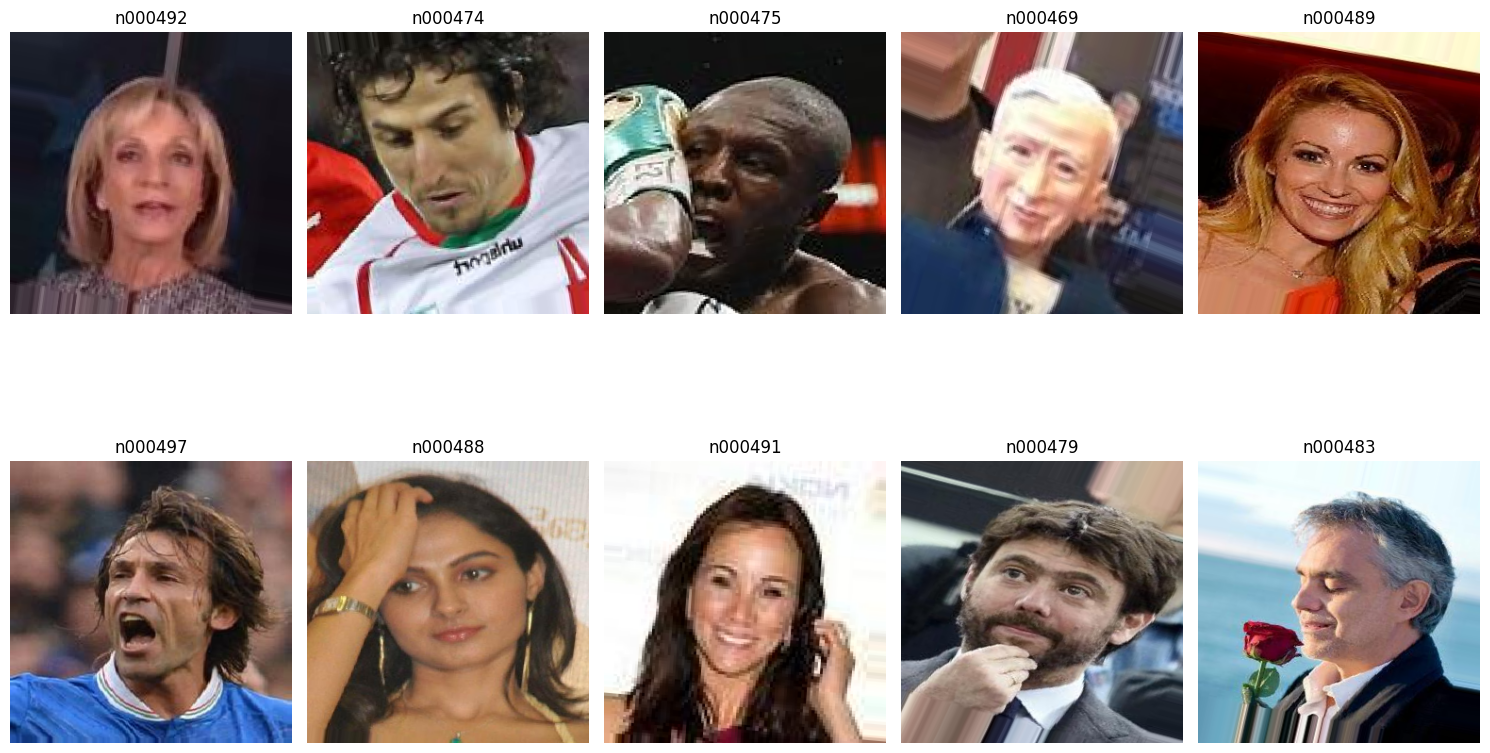

In [6]:
# Retrieve a batch of images and labels
batch_images, batch_labels = next(train_data)

# Track displayed classes
displayed_classes = set()

# Display images, ensuring one per class
plt.figure(figsize=(15, 10))  # Adjust size for up to 10 images
images_shown = 0  # Counter for displayed images
for i in range(len(batch_images)):
    # Get the class label
    label = list(train_data.class_indices.keys())[np.argmax(batch_labels[i])]

    # Skip if this class is already displayed
    if label in displayed_classes:
        continue

    # Add the label to the displayed set
    displayed_classes.add(label)

    # Display the image
    ax = plt.subplot(2, 5, images_shown + 1)  # 2 rows, 5 columns
    plt.imshow(batch_images[i])
    plt.title(label)
    plt.axis("off")

    images_shown += 1
    if images_shown == 10:  # Stop after showing 10 images
        break

plt.tight_layout()
plt.show()


# Xception

In [7]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers

# Load the Xception model with pretrained weights
base_model = Xception(
    weights='/kaggle/input/xception-wieghts/tensorflow2/default/1/xception_weights_tf_dim_ordering_tf_kernels_notop.h5',  # Use weights without the top layers
    include_top=False,  # Ensure include_top=False matches the weights file
    input_shape=(img_height, img_width, 3)
)

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
# Freeze all layers before the last block
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add custom layers for your classification task
model = models.Sequential([
    base_model,  # Pretrained Xception model
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.5),
    layers.Dense(40, activation='softmax')  # 40 classes
])

# Build the model by passing a dummy input
model.build((None, img_height, img_width, 3))

# Compile the model with a learning rate scheduler
optimizer = Adam(learning_rate=0.0001)  # Small learning rate for fine-tuning
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add a learning rate scheduler to reduce the learning rate when validation accuracy plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

# Summary of the model
model.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │        41,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,008,848 (87.77 MB)

 Trainable params: 7,639,592 (29.14 MB)

 Non-trainable params: 15,369,256 (58.63 MB)

# Training

In [8]:
from tensorflow.keras.callbacks import  ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6
)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    steps_per_epoch=train_data.samples // batch_size,
    validation_steps=val_data.samples // batch_size,
    callbacks=[lr_scheduler]
)


Epoch 1/50


I0000 00:00:1734532499.840942     120 service.cc:145] XLA service 0x7b6764012b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734532499.841011     120 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734532499.841016     120 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-12-18 14:35:08.181548: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-18 14:35:08.18415

276/276 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.1495 - loss: 16.7912 - val_accuracy: 0.5643 - val_loss: 13.5775 - learning_rate: 1.0000e-04
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.4062 - loss: 13.5044 - val_accuracy: 0.5833 - val_loss: 13.5536 - learning_rate: 1.0000e-04
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 221s 786ms/step - accuracy: 0.4964 - loss: 13.0554 - val_accuracy: 0.6824 - val_loss: 11.0379 - learning_rate: 1.0000e-04
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - accuracy: 0.4062 - loss: 11.9478 - val_accuracy: 0.6667 - val_loss: 10.9334 - learning_rate: 1.0000e-04
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 216s 765ms/step - accuracy: 0.6193 - loss: 10.7988 - val_accuracy: 0.7358 - val_loss: 9.1822 - learning_rate: 1.0000e-04
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - accuracy: 0.6875 - loss: 9.2432 - val_accuracy: 0.5833 - val_loss: 9.7886 - learning_rate: 1.0000e-04
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 216s 767ms/

# Testing

In [9]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")


162/162 ━━━━━━━━━━━━━━━━━━━━ 68s 419ms/step - accuracy: 0.9448 - loss: 0.4806
Test Accuracy: 0.93


In [10]:
# Predictions and true labels
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

162/162 ━━━━━━━━━━━━━━━━━━━━ 44s 258ms/step


Classification Report:
              precision    recall  f1-score   support

     n000059       0.95      0.96      0.96       108
     n000070       0.94      0.98      0.96       122
     n000083       0.96      0.97      0.97       198
     n000425       0.91      0.96      0.93       120
     n000462       0.85      0.94      0.89       120
     n000463       0.94      0.79      0.86       132
     n000464       0.93      0.95      0.94       132
     n000465       0.91      0.96      0.93       120
     n000466       0.97      0.99      0.98       132
     n000467       0.97      0.95      0.96       132
     n000468       1.00      1.00      1.00        96
     n000469       0.97      1.00      0.99       132
     n000471       0.99      1.00      0.99       132
     n000472       0.87      0.95      0.91       156
     n000473       0.93      0.83      0.88       120
     n000474       0.94      0.95      0.94        96
     n000475       0.95      0.87      0.91       132
    

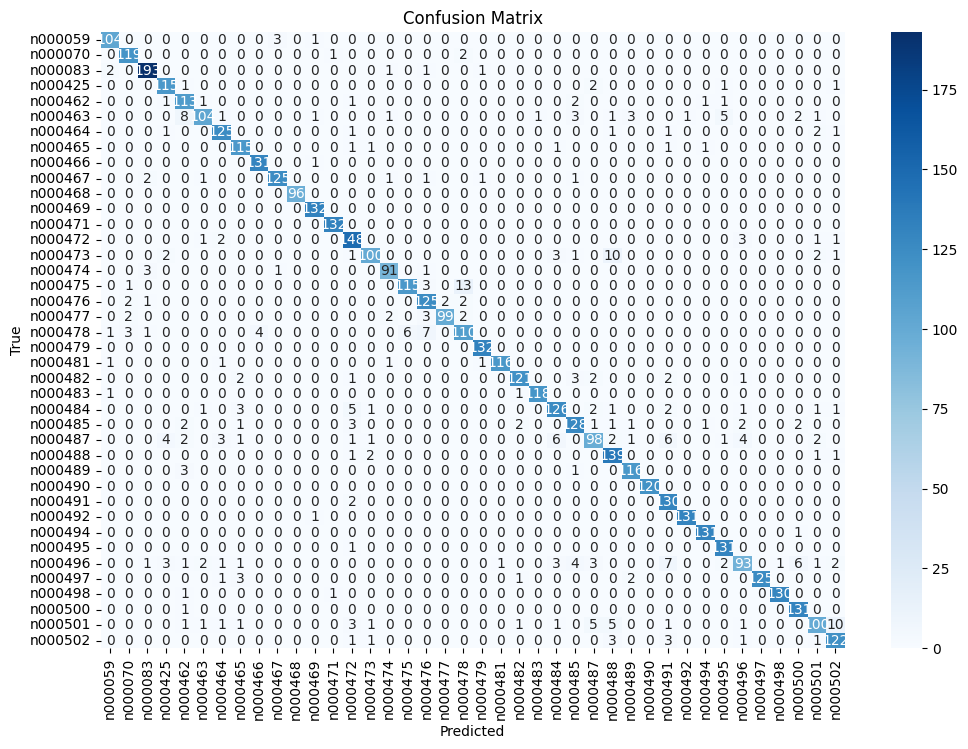

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

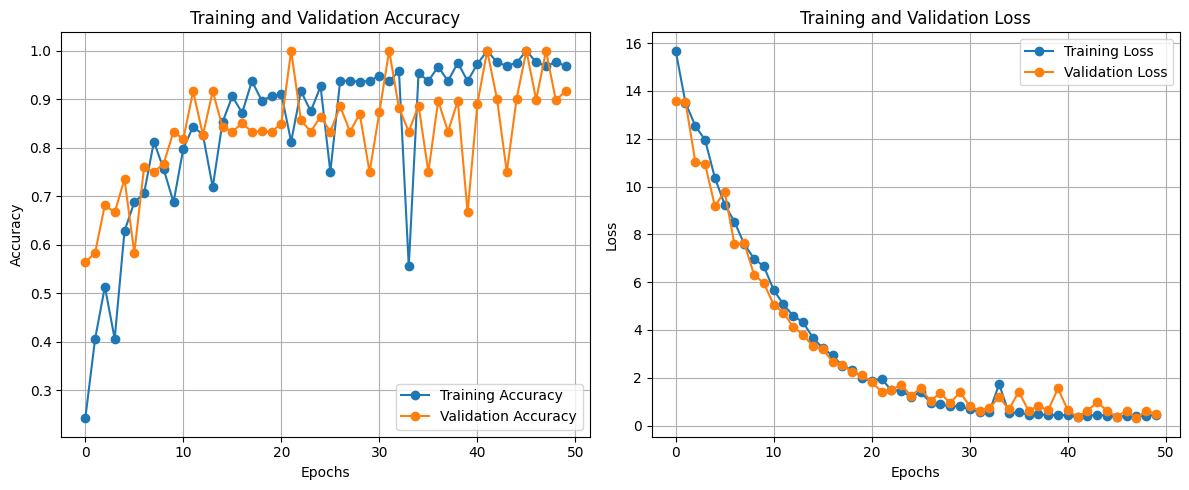

In [15]:


# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot Accuracy
ax[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Plot Loss
ax[1].plot(history.history['loss'], label='Training Loss', marker='o')
ax[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


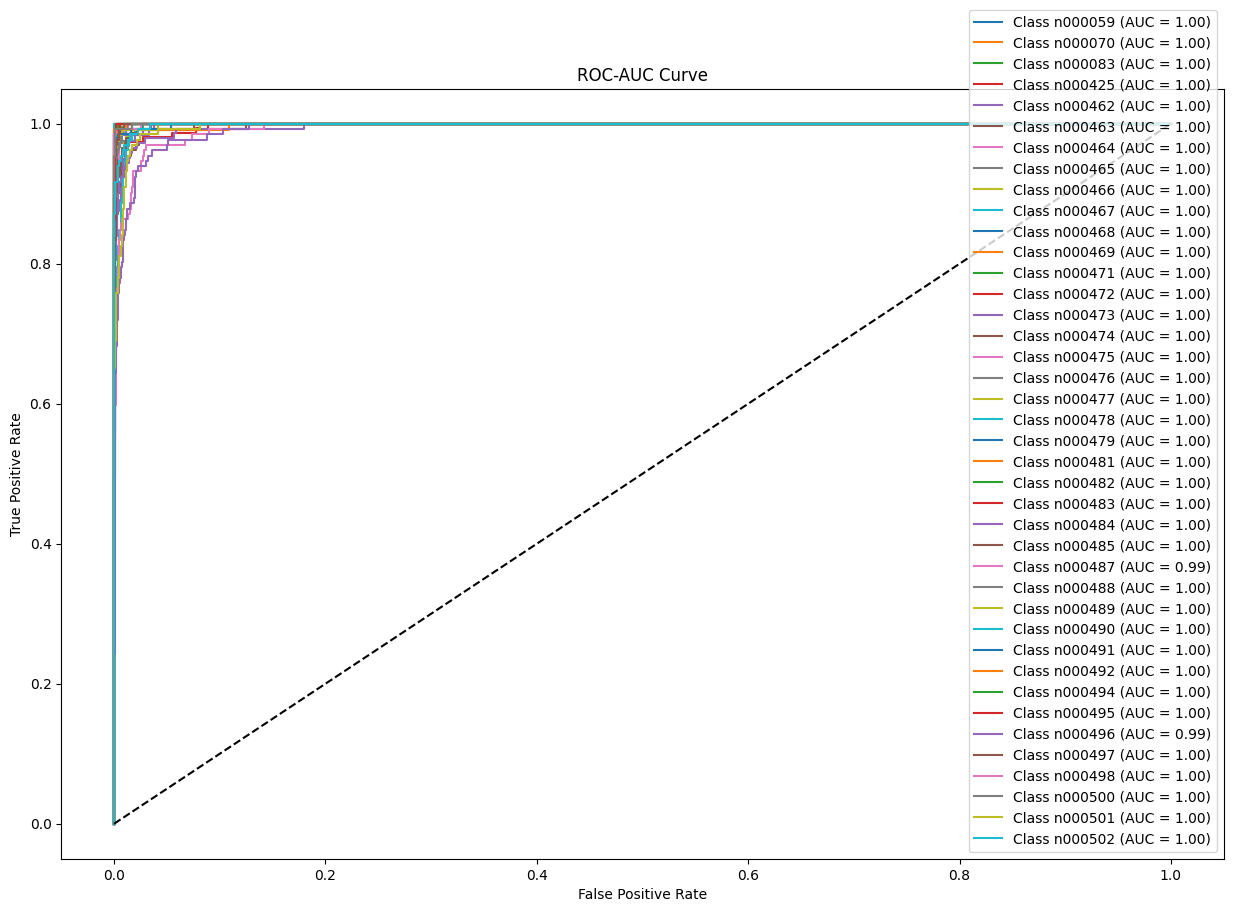

In [20]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(train_data.num_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(15, 10))
for i in range(train_data.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [19]:
model.save('final_xception_finetuned_model.keras')
print("Model saved as final_xception_finetuned_model.keras")

Model saved as final_xception_finetuned_model.keras


In [21]:
from tensorflow.keras.models import load_model
loaded_xception = load_model('/kaggle/working/final_xception_finetuned_model.keras')

In [25]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
# Initialize ImageDataGenerator with the same preprocessing
datagen = ImageDataGenerator(rescale=1./255)  # Normalizing by 1./255

img = image.load_img('/kaggle/input/vgg-face-test-train/test/test/n000070/0007_01.jpg', target_size=(299, 299))  # Replace with your image path

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array = datagen.standardize(img_array)  # Applies the rescaling from ImageDataGenerator


In [26]:
# Predict using the model
predictions = loaded_xception.predict(img_array)
# Get the class with the highest probability (for classification)
pred = train_data.class_indices
pred = np.argmax(predictions, axis=-1)
# If it's a classification model, print the predicted class
print(f"Predicted Class: {pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Class: [1]


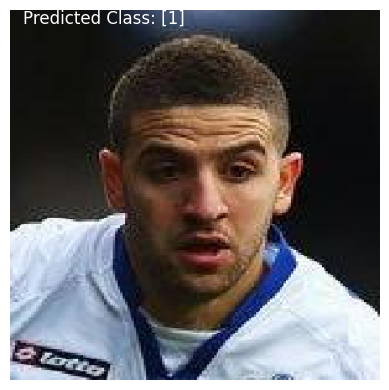

In [27]:
# Display the image
plt.imshow(img)
plt.text(10, 10, f"Predicted Class: {pred}", color='white', fontsize=12)
plt.axis('off')  # Hide axis
plt.show()
